# C1W3A1_Lite_Planar data classification with one hidden layer

## 1 - Packages
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 2 - Dataset

In [2]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400  # number of examples
    N = int(m / 2)  # number of points per class
    D = 2  # dimensionality
    X = np.zeros((m, D))
    Y = np.zeros((m, 1), dtype='uint8')
    a = 4  # maximum ray of the flower

    for j in range(2):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(j * 3.12,
                        (j + 1) * 3.12, N) + np.random.randn(N) * 0.2  # theta
        r = a * np.sin(4 * t) + np.random.randn(N) * 0.2  # radius
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        Y[ix] = j
    X = X.T
    Y = Y.T
    return X, Y

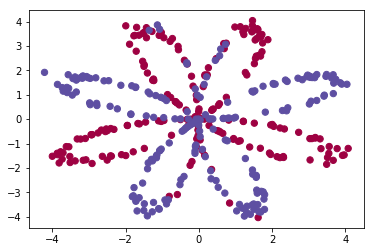

In [3]:
X, Y = load_planar_dataset()
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral)

- a numpy-array (matrix) X that contains your features (x1, x2)
- a numpy-array (vector) Y that contains your labels (red:0, blue:1).



In [4]:
shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1] # training set size
print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


## 3 - Simple Logistic Regression

In [5]:
classifier = sklearn.linear_model.LogisticRegression(solver="lbfgs")
classifier.fit(X.T,Y.T.ravel())
# 源代码此处不加solver=‘lbfgs’ 和 .ravel() 会出现 warning

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [6]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=np.squeeze(y), cmap=plt.cm.Spectral)

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


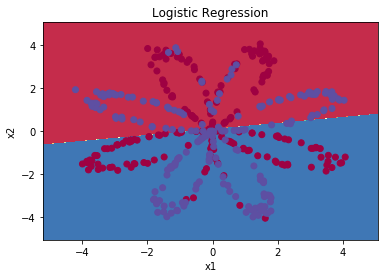

In [7]:
plot_decision_boundary(lambda x: classifier.predict(x), X, Y)
plt.title("Logistic Regression")

LR_predictions = classifier.predict(X.T)
print('Accuracy of logistic regression: %d ' %
      float((np.dot(Y, LR_predictions) + 
             np.dot(1 - Y, 1 - LR_predictions)) / float(Y.size) * 100) + '% ' +
      "(percentage of correctly labelled datapoints)")

## 4 - Neural Network model

**Here is  model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small $$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

### 4.1 - Defining the neural network structure

In [8]:
def layer_sizes(X, Y):
    n_x = X.shape[0]  # size of input layer
    n_h = 4           # size of the hidden layer
    n_y = Y.shape[0]  # size of output layer
    return n_x, n_h, n_y

### 4.2 - Initialize the model's parameters

In [9]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

### 4.3 - The Loop

In [10]:
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

In [11]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

$A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small$$

the cross-entropy loss:
$$L(y^{(i)},a^{[2] (i)}) = - \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$$

In [12]:
def compute_cost(A2, Y, parameters):
    m = Y.shape[1]  # (1,m)
    logprobs = np.multiply(np.log(A2), Y)
    cost = -np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

<img src="images/grad_summary.png" style="width:600px;height:300px;">


$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)}) \space \space \space \space \space$ $\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} \space \space \space \space \space $ $\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) \space \space \space \space $ $\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T \space \space \space \space $ $\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    


- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [13]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2 = A2 - Y
    dW2 = 1 / m * np.dot(dZ2, A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = 1 / m * np.dot(dZ1, X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return grads

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">


In [14]:
def update_parameters(parameters, grads, learning_rate=1.2):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    dW2 = grads["dW2"]
    db1 = grads["db1"]
    db2 = grads["db2"]

    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    b1 = b1 - learning_rate * db1
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1, "W2": W2, "b1": b1, "b2": b2}

    return parameters

### 4.4 - Integrate parts 4.1 4.2 & 4.3 in nn_model()

In [15]:
def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]

    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)

        if print_cost and i % 1000 == 0:
            print("Cost after iteration %i : %f" % (i, cost))

    return parameters

### 4.5 Predictions
**Reminder**:
predictions = $y_{prediction} = \mathbb 1 {activation > 0.5} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

In [16]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    return predictions

Cost after iteration 0 : 138.613963
Cost after iteration 1000 : 57.643326
Cost after iteration 2000 : 50.677062
Cost after iteration 3000 : 46.632785
Cost after iteration 4000 : 45.276968
Cost after iteration 5000 : 44.448380
Cost after iteration 6000 : 43.847601
Cost after iteration 7000 : 43.384818
Cost after iteration 8000 : 39.826939
Cost after iteration 9000 : 39.507378


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

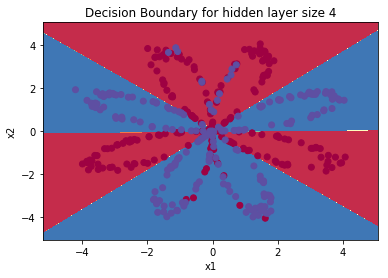

In [17]:
parameters = nn_model(X, Y, n_h=4, num_iterations=10000, print_cost=True)

plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [21]:
predictions = predict(parameters, X)
print('Accuracy: %d' %
      float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) /
      float(Y.size) * 100)+'%')

Accuracy: 90%


### 4.6 - Tuning hidden layer size (optional/ungraded exercise)

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 10 hidden units: 90.25 %
Accuracy for 20 hidden units: 90.5 %


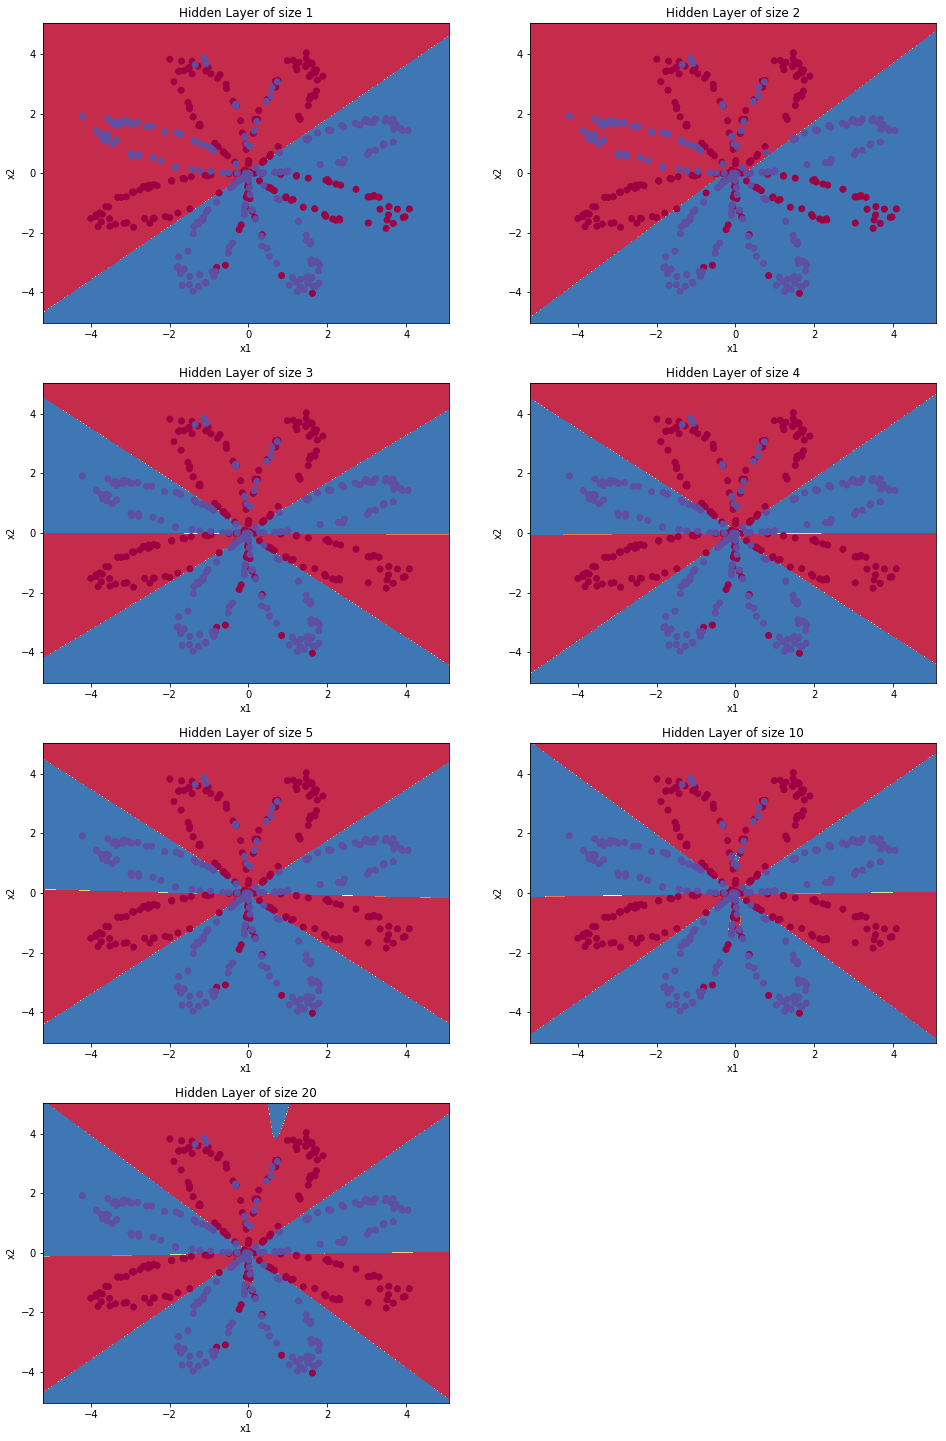

In [22]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 10, 20]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float(
        (np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) /
        float(Y.size) * 100)
    print("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

## 5 - Performance on other datasets

In [23]:
# Dataasets
def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N,
                                                  factor=0.5,
                                                  noise=0.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=0.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N,
                                        random_state=5,
                                        n_features=2,
                                        centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(
        mean=None,
        cov=0.5,
        n_samples=N,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

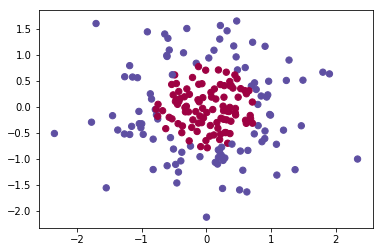

In [30]:
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets(
)
datasets = {
    "noisy_circles": noisy_circles,
    "noisy_moons": noisy_moons,
    "blobs": blobs,
    "gaussian_quantiles": gaussian_quantiles
}
dataset = "gaussian_quantiles"
X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])
if dataset == "blobs":
    Y = Y % 2

plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral)

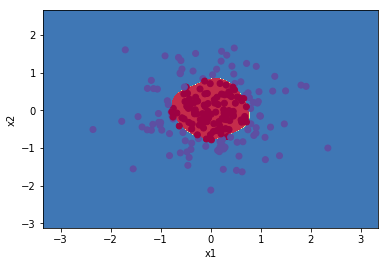

In [31]:
parameters = nn_model(X, Y, n_h, num_iterations=5000)
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/